# metagenomeSeq differential abundance analysis script
## 2020-04-13

This script has in essence the same content as CSS.R (with some debugging). The aim is to have the information in a nice-formatted document.

Scripts to reproduce the Figures  of Pérez-Jaramillo et al., 2016  
Differential abundant features analysis using a Zero Inflated Gaussian Model
from Paulson et al, 2013.

Juan Esteban Pérez Jaramillo - Victor J. Carrión  
Netherlands Institute of Ecology  
j.perez@nioo.knaw.nl  
biojep@gmail.com

## Code
Importing libraries:

In [ ]:
library("mime")
library("httpuv")
library("metagenomeSeq")
library("ggplot2")
library("NetComp")

Import data:

In [2]:
getwd()
tmp = loadMeta("Matriz_final_rhizosphere_asv-copia.tsv", sep = "\t") #Cargar tabla de ASVs
taxa = read.delim("taxonomy_final_rhizosphere.tsv", header=TRUE, row.names = 1, stringsAsFactors = FALSE, sep = "\t") #Cargar taxonomía
mapfile = loadPhenoData("metadata_rhizosphere.tsv", tran = TRUE) #Cargar metadatos
phenotypeData = AnnotatedDataFrame(mapfile) #Convertir metadatos
OTUdata = AnnotatedDataFrame(taxa) #Convertir taxonomía
obj = newMRexperiment(tmp$counts, phenoData = phenotypeData, featureData = OTUdata)
head(MRcounts(obj[, 1:36])) #Mirar Columnas#

[1] "/home/nesper/Documentos/genomeseq/rhizosphere/metagenomeSeq/metagenomeSeq-abund"

,A1_1,A1_2,A1_3,A1_4,A2_1,A2_2,A2_3,A2_4,L1_1,L1_2,⋯,M4_3,M4_4,M5_1,M5_2,M5_3,M5_4,S_1,S_2,S_3,S_4
ASV1,342,239,1076,322,299,437,237,928,566,605,⋯,482,423,824,312,940,455,0,0,0,0
ASV2,354,239,1064,323,300,393,234,905,571,654,⋯,523,417,815,272,984,467,0,0,0,0
ASV3,310,204,878,269,229,335,224,678,436,527,⋯,395,321,658,236,788,382,0,0,0,0
ASV4,252,213,838,251,258,318,207,656,424,526,⋯,349,328,608,256,786,409,0,0,0,0
ASV5,286,226,868,291,242,361,218,663,418,480,⋯,339,293,579,273,784,378,0,0,0,0
ASV6,236,205,694,254,201,257,152,524,379,442,⋯,279,278,558,202,651,296,0,0,0,0


Calculating the normalization factors:

Default value being used.

Default value being used.



[1] "A1"   "A2"   "L1"   "M1"   "M2"   "M3"   "M4"   "M5"   "Soil"

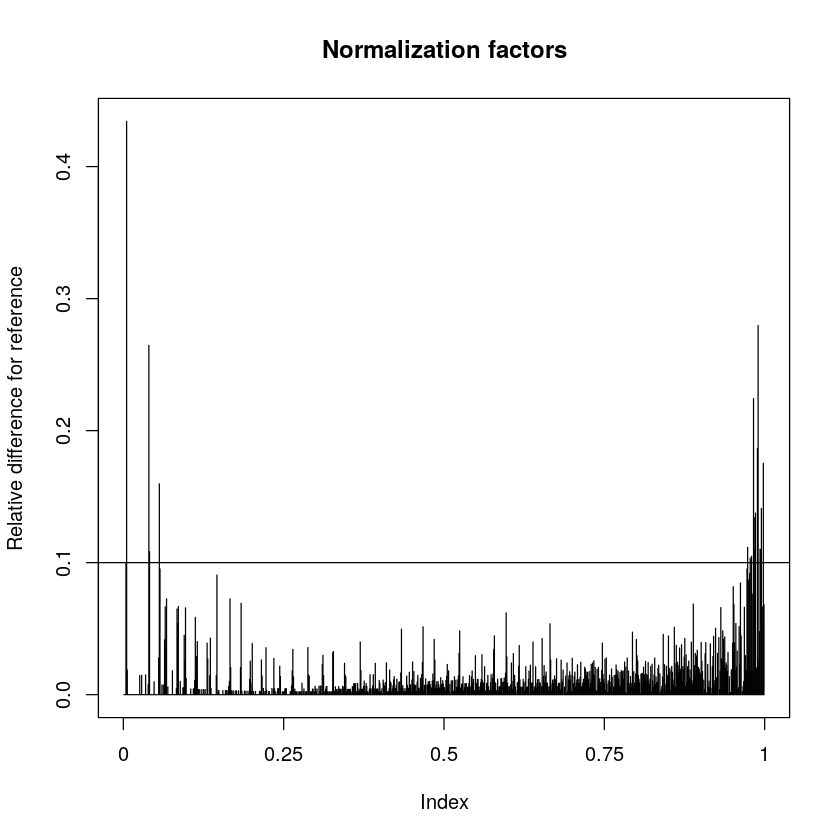

In [3]:
p2 = cumNormStat(obj, pFlag = TRUE, main = "Normalization factors")
obj = cumNorm(obj, p = cumNormStatFast(obj))
normFactor = normFactors(obj)
normFactor = log2(normFactor/median(normFactor) + 1)
settings = zigControl(maxit = 10, verbose = TRUE) #Configuration for fitZig function, maxit: maximum iterations
Accession = pData(obj)$Accession
mod = model.matrix(~Accession)
colnames(mod) = levels(Accession)
colnames(mod)

Normalization to export:

In [4]:
mat = MRcounts(obj, norm = TRUE, log = TRUE)
#mat #See created object

Exporting Normalization:

In [ ]:
exportMat(mat, file = file.path("CSS_normalized_spermosphere2.txt")) #Colocar la ruta y el nombre del archivo#

In [5]:
res = fitZig(obj = obj, mod = mod, useCSSoffset = TRUE, control = settings)
res@fit
zigFit = res@fit
finalMod = res@fit$design
finalMod

it= 0, nll=42.34, log10(eps+1)=Inf, stillActive=13833
it= 1, nll=36.21, log10(eps+1)=0.08, stillActive=13364
it= 2, nll=46.93, log10(eps+1)=0.05, stillActive=888
it= 3, nll=47.53, log10(eps+1)=0.05, stillActive=118
it= 4, nll=47.59, log10(eps+1)=0.06, stillActive=22
it= 5, nll=47.61, log10(eps+1)=0.00, stillActive=1
it= 6, nll=47.62, log10(eps+1)=0.00, stillActive=0


,A1,A2,L1,M1,M2,M3,M4,M5,Soil,scalingFactor
ASV1,13.1551785,0.169341945,0.18945883,-0.49148941,0.01955645,-0.10963881,0.7074016,0.175867167,-8.4015309,-1.7188242
ASV2,13.1112057,0.107302699,0.22546416,-0.56183885,-0.05911788,-0.05270619,0.7268104,0.142701811,-8.4143798,-1.6982758
ASV3,12.7223040,0.067212297,0.13381505,-0.45173206,-0.04293907,-0.03483955,0.6124292,0.112303196,-8.1842373,-1.6408644
ASV4,11.9198939,0.125965917,0.18941924,-0.44275501,0.02425785,0.11274525,0.5997607,0.286345353,-8.1278707,-1.3710664
ASV5,12.3504918,0.049370355,0.04213465,-0.62446241,-0.09888198,-0.12031086,0.4277475,0.109210785,-8.2416949,-1.4856479
ASV6,11.9139104,-0.127449798,0.06422158,-0.73180551,-0.17779141,-0.27011287,0.4376643,0.080531443,-8.0209026,-1.4075762
ASV7,12.2549976,0.157272218,0.14384576,-0.51360159,-0.10619629,-0.02690917,0.6126850,0.171017137,-7.8459877,-1.5942113
ASV8,12.1264313,0.115647984,0.18066430,-0.60341714,0.02481536,-0.08644290,0.6678844,0.147919285,-7.8009389,-1.5639680
ASV9,12.1192761,0.042662713,0.08364683,-0.56104122,-0.18517279,0.01096754,0.5026609,0.116601976,-7.8421435,-1.5465186
ASV10,11.8263332,0.221205964,0.24567587,-0.34215181,0.11293280,0.01301040,0.6834962,0.353432188,-7.6862257,-1.4969539


,A1,A2,L1,M1,M2,M3,M4,M5,Soil,scalingFactor
1,1,0,0,0,0,0,0,0,0,2.287472
2,1,0,0,0,0,0,0,0,0,3.102658
3,1,0,0,0,0,0,0,0,0,2.298072
4,1,0,0,0,0,0,0,0,0,2.716332
5,1,1,0,0,0,0,0,0,0,2.763624
6,1,1,0,0,0,0,0,0,0,2.878921
7,1,1,0,0,0,0,0,0,0,2.934517
8,1,1,0,0,0,0,0,0,0,2.209453
9,1,0,1,0,0,0,0,0,0,2.833902
10,1,0,1,0,0,0,0,0,0,2.654436


Following command results in error:

In [6]:
contrast.matrix = makeContrasts(Wild_A - Variety_G, levels = finalMod)

ERROR: Error in eval(ej, envir = levelsenv): objeto 'Wild_A' no encontrado
